In [2]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from skimage import draw
from multiprocessing import Pool, TimeoutError
import pickle
import dlib

In [3]:
# pretrain model source: https://github.com/italojs/facial-landmarks-recognition
pretrained_model_path = './images/inputs/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(pretrained_model_path)

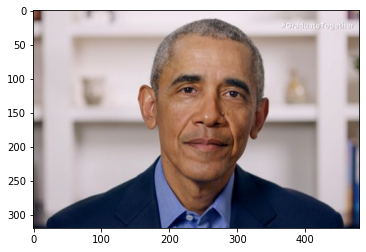

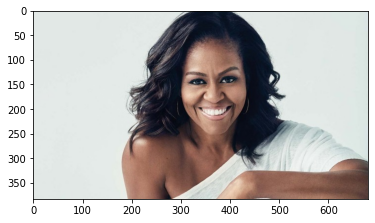

In [4]:
face_img_1 = cv2.imread('./images/inputs/face-4.jpeg')
fig = plt.figure()
plt.imshow(face_img_1[:,:,[2,1,0]])

face_img_2 = cv2.imread('./images/inputs/face-3.jpeg')
fig = plt.figure()
plt.imshow(face_img_2[:,:,[2,1,0]])


In [5]:
def get_landmarks(img, num_keypoints, random_index):
    # Get the landmark points
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detected_faces_region = detector(img_grey, 1)
    if len(detected_faces_region) != 1:
        print('image contain more than one faces')
        return None
    for face in detected_faces_region:
        shape = predictor(img_grey, face)
        shape_np = np.zeros((68, 2), dtype="int")
        #random_index = random.sample(range(68), num_keypoints)

        for i in random_index:
            shape_np[i] = (shape.part(i).x, shape.part(i).y)
        shape = shape_np
        # visualize the keypoint
        for i, (x, y) in enumerate(shape):
            cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
    fig = plt.figure()
    plt.imshow(img[:,:,[2,1,0]])
    return shape_np

In [6]:
def get_img_corners(img):
    '''
    Returns the position of the corners of an color image
    Input:
        img: color image.
    Output:
        corners: image corners (np.array)
    '''
    corners = np.zeros((4, 1, 2), dtype=np.float32)

    height, width, channels = img.shape
    corners[0] = (0, 0) #top left
    corners[1] = (width, 0) #top right
    corners[2] = (width, height) #bottom right
    corners[3] = (0, height) #bottom left

    return corners

def add_corner_points(img, points):
    corners = get_img_corners(img).astype(np.int64)
    for corner_point in corners:
        points = np.append(points, corner_point, axis=0)
    return points

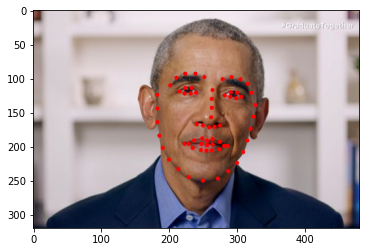

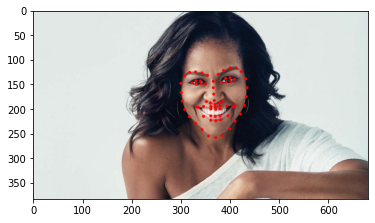

In [7]:
import random

num_keypoints = 68
random_index = random.sample(range(68), num_keypoints)
points = get_landmarks(face_img_1.copy(), num_keypoints, random_index)
points_2 = get_landmarks(face_img_2.copy(), num_keypoints, random_index)

points = add_corner_points(face_img_1, points)
points_2 = add_corner_points(face_img_2, points_2)

In [8]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

def get_mask(triangle, img):
    ys = triangle[:,1]
    xs = triangle[:,0]
    mask = poly2mask(ys, xs, img.shape[:2])
#     fig = plt.figure()
#     plt.imshow(np.uint8(mask), cmap='gray')
    return mask


In [9]:
points = np.array(points)
points_2 = np.array(points_2)
len(points)==len(points_2)

True

In [10]:
img = face_img_1
img2 = face_img_2

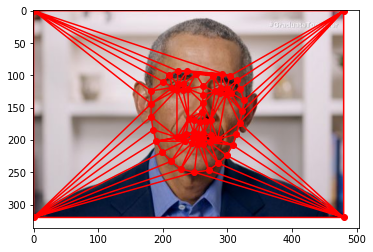

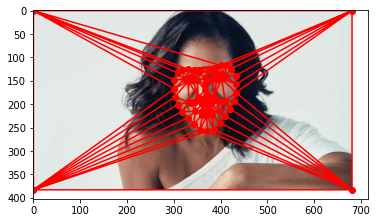

In [11]:
%matplotlib inline
test = tri.Triangulation(points_2[:,0], points_2[:,1]).get_masked_triangles()
fig = plt.figure()
plt.imshow(img[:,:,[2,1,0]])
# triang = tri.Triangulation(points[:,0], points[:,1])
plt.triplot(points[:,0], points[:,1], test, c='r')
plt.plot(points[:,0], points[:,1], 'ro')
fig = plt.figure()
plt.imshow(img2[:,:,[2,1,0]])
# triang = tri.Triangulation(points[:,0], points[:,1])
plt.triplot(points_2[:,0], points_2[:,1], test, c='r')
plt.plot(points_2[:,0], points_2[:,1], 'ro')

In [ ]:
if __name__ == '__main__':
    import utils
    points = np.array(points)
    points_2 = np.array(points_2)
    test = tri.Triangulation(points_2[:,0], points_2[:,1]).get_masked_triangles()
    duration = 3 # in seconds
    fps = 30
    num_frames = duration * fps
    pool = Pool()
    results = []
    positions = np.zeros(img.shape[:2],dtype=np.ndarray)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            positions[y,x]=[x,y]
    ori_tris = points[test]
    new_tris = points_2[test]
    ori_img = img
    new_img = img2
    argument = [(ori_tris, new_tris, frame_num / num_frames, ori_img,new_img,positions,frame_num, 'with_auto_keypoint') for frame_num in range(0, num_frames)]

    result = pool.starmap(utils.generate_imgs, argument)
    print("here")

In [102]:
# write the video
frames_dir = 'images/outputs/with_auto_keypoint/'
video_output_dir = 'images/outputs/triangulate_auto_keypoint.mpeg'
utils.imageFolder2mpeg(frames_dir, video_output_dir, fps=fps)
print('done')


OpenCV: FFMPEG: tag 0x3147504d/'MPG1' is not supported with codec id 1 and format 'mpeg / MPEG-1 Systems / MPEG program stream'


done
